# Model Testing
This notebook is used to test a variety of parameters for modeling, using one "chunk" of data (5000 phrases, approx 47000 words, about 2.5% of total dataset). Overfitting was a very common problem, and even strong regularization often didn't correct it. Lambda value of 0.1 had best results, but it's still overfitting.

### Factors found to have best results:
* activation = tanh
* optimizer = sgd
* one large hidden layer
* little to no dropout
* L2 regularization

In [1]:
import pandas as pd
import numpy as np

temp = pd.read_csv('Data/cv-valid-train.csv')
texts = temp['text']

words_list = np.hstack([x.split(' ') for x in texts])
words_list_df = pd.Series(words_list)
temp = words_list_df.value_counts()

common_words = temp[:1000]
for ind in range(1000,len(temp)):
    num_freq = common_words[-1]
    if temp[ind] == num_freq:
        common_words = pd.concat([common_words,temp[ind:ind+1]])
    else: break
print(common_words)

temp = None
texts = None
words_list = None


df = pd.read_csv('Data/Samples_1.csv')
df['words'] = df['words'].where(df['words'].isin(common_words.index),'[UNRECOGNIZED]')
temp = df.loc[df['words']=='[UNRECOGNIZED]']
df_1 = df.loc[df['words']!='[UNRECOGNIZED]']
df_2 = temp.sample(frac=0.005)
df = pd.concat([df_1,df_2])
print(len(df))
df.head()

the         141274
to           55997
and          41557
a            40516
of           36293
             ...  
eastward       230
wasted         230
awoke          230
medaling       230
olympics       230
Length: 1009, dtype: int64
40900


,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,...,sample_2991,sample_2992,sample_2993,sample_2994,sample_2995,sample_2996,sample_2997,sample_2998,sample_2999,words
0,129,206,227,208,275,402,474,559,658,880,...,-6458,-4407,-2736,-1968,0,0,0,0,0,learn
1,-4786,-3695,-694,2025,3114,2906,1890,1563,2868,4372,...,6378,-4740,-14274,-14041,0,0,0,0,0,to
3,718,165,-1624,-1544,1007,620,1096,-1256,-1975,60,...,345,1353,1125,-5120,-5043,-3150,-4747,-5659,-5833,omens
4,320,-109,590,895,389,334,871,948,1581,1838,...,-20211,-20799,-21697,-18167,0,0,0,0,0,and
6,508,-265,-1375,-2541,-3028,-2754,-2325,-2041,-2351,-2699,...,41,-133,-379,-513,0,0,0,0,0,them


In [66]:
df['words'].value_counts()['[UNRECOGNIZED]']

32

In [53]:
import sys
sys.getsizeof(X)/1000000000 + sys.getsizeof(y)/1000000000

1.327168432

In [23]:
5000/195776

0.02553939195815626

In [24]:
1.14/0.0255

44.705882352941174

Text(0, 0.5, 'Gigabytes')

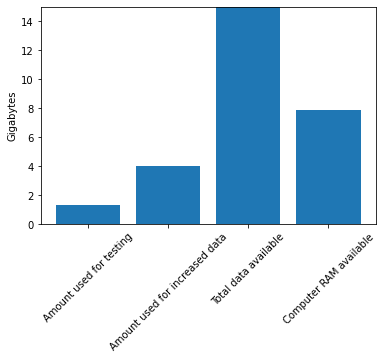

In [57]:
amt_used = 1.327
more_amt_used = 3*amt_used
total = 44.7
comp_mem = 7.88
plt.bar(['Amount used for testing','Amount used for increased data','Total data available','Computer RAM available'],
        [amt_used,more_amt_used,total,comp_mem])
plt.ylim(0,15)
plt.xticks(rotation=45)
plt.ylabel('Gigabytes')

([0, 1, 2], <a list of 3 Text major ticklabel objects>)

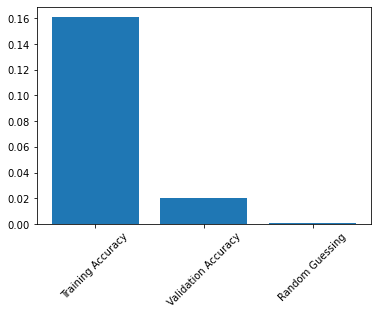

In [78]:
plt.bar(['Training Accuracy','Validation Accuracy','Random Guessing'],
        [0.161,0.0201,1/1000])
plt.xticks(rotation=45)

In [2]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint



X = df.drop('words',axis=1)
y_raw = df['words']

lb = LabelBinarizer()
y = lb.fit_transform(y_raw)
print(y.shape)


X_train,X_val,y_train,y_val = train_test_split(X,y)
ss = StandardScaler()
X_train_scale = ss.fit_transform(X_train)
X_val_scale = ss.transform(X_val)


y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

if len(d_class_weights)<y.shape[1]:
    init_len = len(d_class_weights)
    diff = y.shape[1]-init_len
    for i in range(diff):
        ind = init_len + i
        d_class_weights[ind] = 0

early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

Using TensorFlow backend.


(40900, 1009)


D:\Alex\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[   0    1    2 ... 1006 1007 1008], y=[ 75 590  26 ... 793 486 873] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [5]:
# this cell used to test converting data back to audio format-to make sure the values represent
# what they're supposed to represent

from pydub import AudioSegment

ind = 3
samps = np.array(X.iloc[ind])
frame_rate = 18987
#note: frame_rate is educated guess, will vary based on number of syllables and length of original audio
audio_segment = AudioSegment(samps,frame_rate=frame_rate,
                             sample_width=2,channels=1)
print(f'The word at index {ind} is "{y_raw[ind]}"')
audio_segment

The word at index 3 is "omens"


In [74]:
y_raw.value_counts()

the          3615
to           1481
and          1084
a            1026
of            931
             ... 
whether         2
smoking         2
reception       2
shadow          2
lower           1
Name: words, Length: 1009, dtype: int64

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

## Final Model
* lambda = 0.1

Lambda = 0.1
30675/30675 [==============================] - 19s 606us/step
----------
Training Loss: 7.48 
Training Accuracy: 0.161
10225/10225 [==============================] - 6s 561us/step
----------
Validation Loss: 8.98 
Validation Accuracy: 0.0201


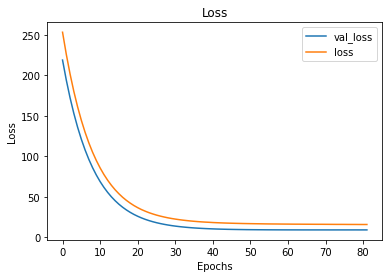

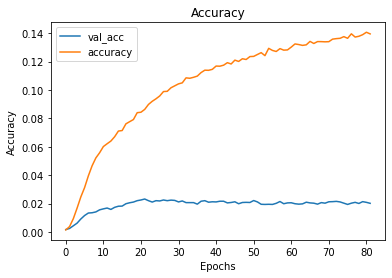

In [79]:
smaller_lambda = models.Sequential()
smaller_lambda.add(layers.Dropout(0.1,input_shape=(3000,)))
smaller_lambda.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.1)))
smaller_lambda.add(layers.Dense(y.shape[1],activation='softmax'))
smaller_lambda.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



sl_res=smaller_lambda.fit(X_train_scale,y_train,epochs=100,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Lambda = 0.1')
results_train = smaller_lambda.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = smaller_lambda.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(sl_res)

Compare a variety of optimizers:
* sgd (above) - Train Loss: 7.5, Val Loss: 9
* RMSprop - 10.5, 13
* Adam - 9, 11.5
* Nadam - 13, 15
* Adagrad - 6.4, 10
* Adamax - 8, 10

RMSprop
30675/30675 [==============================] - 16s 515us/step
----------
Training Loss: 10.5 
Training Accuracy: 0.176
10225/10225 [==============================] - 5s 533us/step
----------
Validation Loss: 12.8 
Validation Accuracy: 0.00714


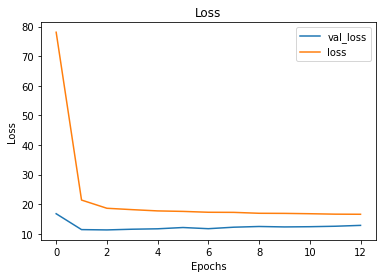

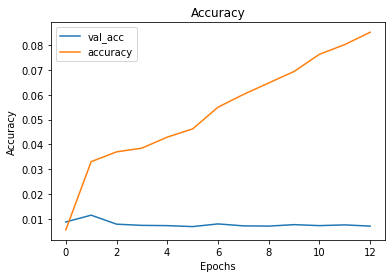

Adam
30675/30675 [==============================] - 16s 507us/step
----------
Training Loss: 9.19 
Training Accuracy: 0.2
10225/10225 [==============================] - 5s 522us/step
----------
Validation Loss: 11.6 
Validation Accuracy: 0.00655


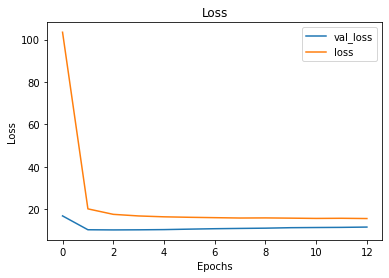

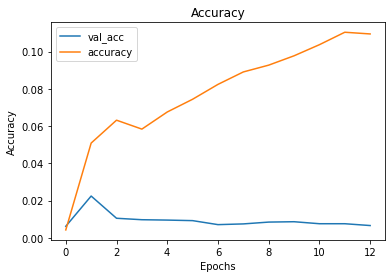

Nadam
30675/30675 [==============================] - 16s 509us/step
----------
Training Loss: 13.2 
Training Accuracy: 0.133
10225/10225 [==============================] - 5s 517us/step
----------
Validation Loss: 15.3 
Validation Accuracy: 0.0045


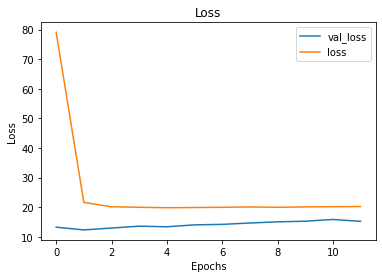

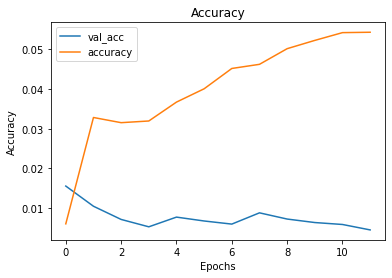

Adagrad
30675/30675 [==============================] - 16s 512us/step
----------
Training Loss: 6.41 
Training Accuracy: 0.344
10225/10225 [==============================] - 5s 500us/step
----------
Validation Loss: 10.3 
Validation Accuracy: 0.00831


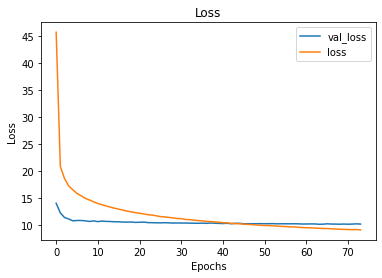

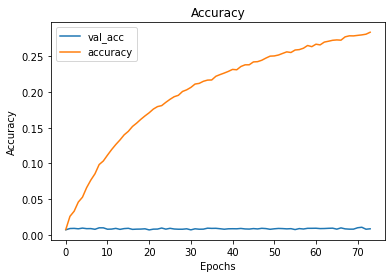

Adamax
30675/30675 [==============================] - 15s 502us/step
----------
Training Loss: 8.17 
Training Accuracy: 0.206
10225/10225 [==============================] - 5s 498us/step
----------
Validation Loss: 10.4 
Validation Accuracy: 0.00753


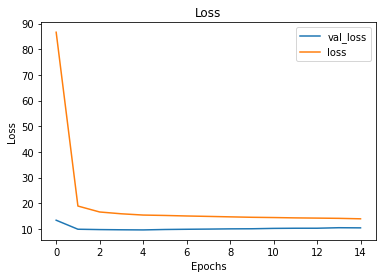

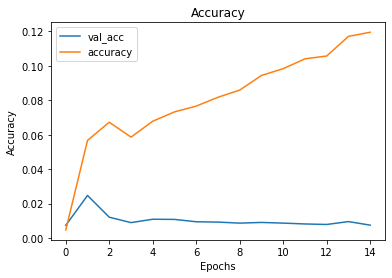

In [4]:
# Testing optimizers

RMSprop_model = models.Sequential()
RMSprop_model.add(layers.Dropout(0.1,input_shape=(3000,)))
RMSprop_model.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.1)))
RMSprop_model.add(layers.Dense(y.shape[1],activation='softmax'))
RMSprop_model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics=['accuracy'])



results=RMSprop_model.fit(X_train_scale,y_train,epochs=100,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('RMSprop')
results_train = RMSprop_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = RMSprop_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)


adam_model = models.Sequential()
adam_model.add(layers.Dropout(0.1,input_shape=(3000,)))
adam_model.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.1)))
adam_model.add(layers.Dense(y.shape[1],activation='softmax'))
adam_model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])



results=adam_model.fit(X_train_scale,y_train,epochs=100,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Adam')
results_train = adam_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = adam_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)


nadam_model = models.Sequential()
nadam_model.add(layers.Dropout(0.1,input_shape=(3000,)))
nadam_model.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.1)))
nadam_model.add(layers.Dense(y.shape[1],activation='softmax'))
nadam_model.compile(loss='categorical_crossentropy',optimizer='Nadam',metrics=['accuracy'])



results=nadam_model.fit(X_train_scale,y_train,epochs=100,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Nadam')
results_train = nadam_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = nadam_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)


adagrad_model = models.Sequential()
adagrad_model.add(layers.Dropout(0.1,input_shape=(3000,)))
adagrad_model.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.1)))
adagrad_model.add(layers.Dense(y.shape[1],activation='softmax'))
adagrad_model.compile(loss='categorical_crossentropy',optimizer='Adagrad',metrics=['accuracy'])



results=adagrad_model.fit(X_train_scale,y_train,epochs=100,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Adagrad')
results_train = adagrad_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = adagrad_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)


adamax_model = models.Sequential()
adamax_model.add(layers.Dropout(0.1,input_shape=(3000,)))
adamax_model.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.1)))
adamax_model.add(layers.Dense(y.shape[1],activation='softmax'))
adamax_model.compile(loss='categorical_crossentropy',optimizer='Adamax',metrics=['accuracy'])



results=adamax_model.fit(X_train_scale,y_train,epochs=100,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Adamax')
results_train = adamax_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = adamax_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)

tanh
30675/30675 [==============================] - 159s 5ms/step
----------
Training Loss: 6.41 
Training Accuracy: 0.344
10225/10225 [==============================] - 48s 5ms/step
----------
Validation Loss: 10.3 
Validation Accuracy: 0.00831
ReLU
30675/30675 [==============================] - 18s 577us/step
----------
Training Loss: 8.81 
Training Accuracy: 0.231
10225/10225 [==============================] - 6s 580us/step
----------
Validation Loss: 11.0 
Validation Accuracy: 0.0106


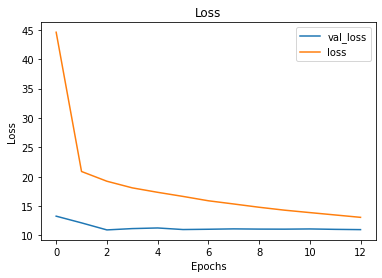

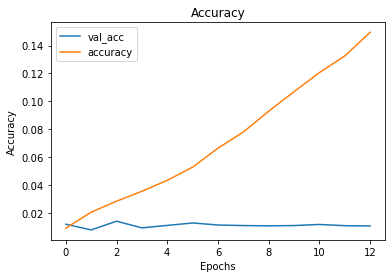

Leaky ReLU
30675/30675 [==============================] - 15s 491us/step
----------
Training Loss: 8.54 
Training Accuracy: 0.215
10225/10225 [==============================] - 5s 473us/step
----------
Validation Loss: 10.9 
Validation Accuracy: 0.00939


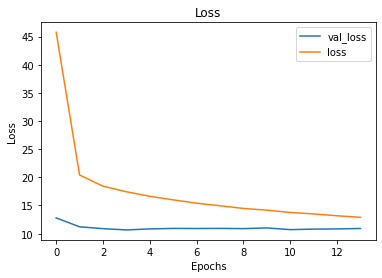

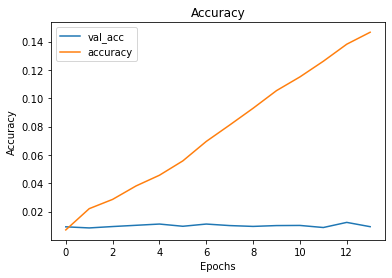

Thresholded ReLU
30675/30675 [==============================] - 15s 504us/step
----------
Training Loss: 6.46 
Training Accuracy: 0.0193
10225/10225 [==============================] - 5s 495us/step
----------
Validation Loss: 6.46 
Validation Accuracy: 0.0199


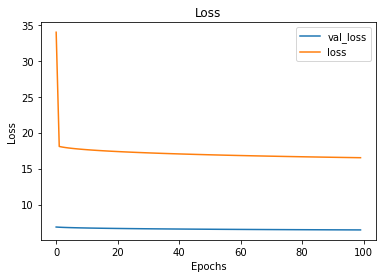

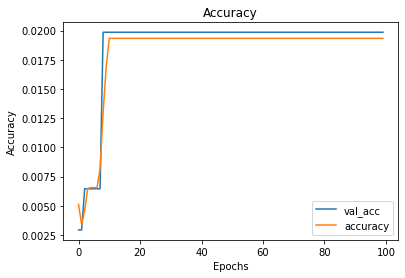

In [5]:
# testing activation functions
# tanh, relu, ThresholdedReLU, LeakyReLU
print('tanh')
results_train = adagrad_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = adagrad_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')


relu_model = models.Sequential()
relu_model.add(layers.Dropout(0.1,input_shape=(3000,)))
relu_model.add(layers.Dense(2000,activation='relu',kernel_regularizer=regularizers.l2(0.1)))
relu_model.add(layers.Dense(y.shape[1],activation='softmax'))
relu_model.compile(loss='categorical_crossentropy',optimizer='Adagrad',metrics=['accuracy'])



results=relu_model.fit(X_train_scale,y_train,epochs=100,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('ReLU')
results_train = relu_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = relu_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)


leaky_model = models.Sequential()
leaky_model.add(layers.Dropout(0.1,input_shape=(3000,)))
leaky_model.add(layers.Dense(2000,kernel_regularizer=regularizers.l2(0.1)))
leaky_model.add(layers.LeakyReLU())
leaky_model.add(layers.Dense(y.shape[1],activation='softmax'))
leaky_model.compile(loss='categorical_crossentropy',optimizer='Adagrad',metrics=['accuracy'])



results=leaky_model.fit(X_train_scale,y_train,epochs=100,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Leaky ReLU')
results_train = leaky_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = leaky_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)


thresh_model = models.Sequential()
thresh_model.add(layers.Dropout(0.1,input_shape=(3000,)))
thresh_model.add(layers.Dense(2000,kernel_regularizer=regularizers.l2(0.1)))
thresh_model.add(layers.ThresholdedReLU())
thresh_model.add(layers.Dense(y.shape[1],activation='softmax'))
thresh_model.compile(loss='categorical_crossentropy',optimizer='Adagrad',metrics=['accuracy'])



results=thresh_model.fit(X_train_scale,y_train,epochs=100,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Thresholded ReLU')
results_train = thresh_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = thresh_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)

sgd
30675/30675 [==============================] - 16s 535us/step
----------
Training Loss: 6.71 
Training Accuracy: 0.0226
10225/10225 [==============================] - 5s 524us/step
----------
Validation Loss: 6.74 
Validation Accuracy: 0.0199


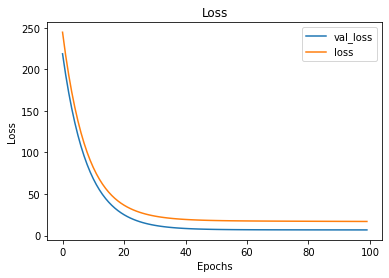

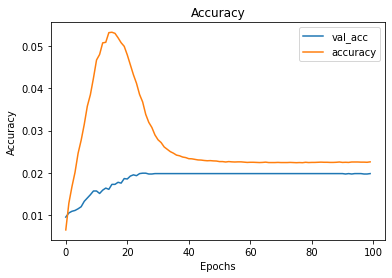

In [6]:
sgd_model = models.Sequential()
sgd_model.add(layers.Dropout(0.1,input_shape=(3000,)))
sgd_model.add(layers.Dense(2000,kernel_regularizer=regularizers.l2(0.1)))
sgd_model.add(layers.ThresholdedReLU())
sgd_model.add(layers.Dense(y.shape[1],activation='softmax'))
sgd_model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



results=sgd_model.fit(X_train_scale,y_train,epochs=100,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('sgd')
results_train = sgd_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = sgd_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Three Hidden Layers (equal size)
30675/30675 [==============================] - 31s 1ms/sample - loss: 7.3837 - accuracy: 0.0227
----------
Training Loss: 7.38 
Training Accuracy: 0.0227
10225/10225 [==============================] - 10s 983us/sample - loss: 7.5590 - accuracy: 0.0134
----------
Validation Loss: 7.56 
Validation Accuracy: 0.0134


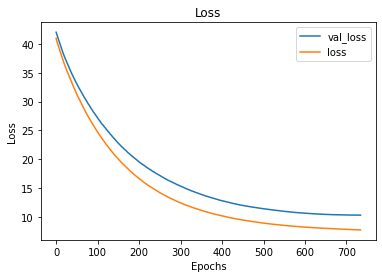

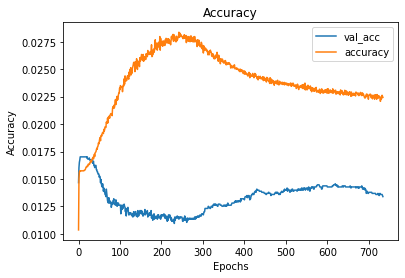

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Three Hidden Layers (decreasing size)
30675/30675 [==============================] - 36s 1ms/sample - loss: 7.4136 - accuracy: 0.0209s - loss: 7.4143 - accu
----------
Training Loss: 7.41 
Training Accuracy: 0.0209
10225/10225 [==============================] - 10s 962us/sample - loss: 7.6435 - accuracy: 0.0032- loss: 7.6466 - accu
----------
Validation Loss: 7.64 
Validation Accuracy: 0.00323


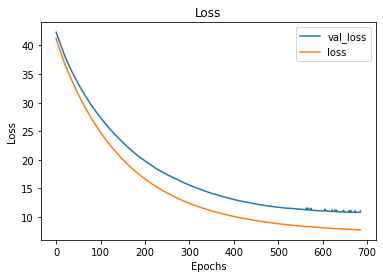

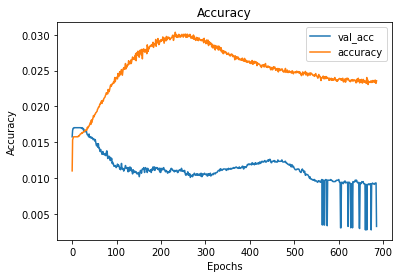

In [5]:
HL_3 = models.Sequential()
HL_3.add(layers.Dropout(0.1,input_shape=(3000,)))
HL_3.add(layers.Dense(2000,kernel_regularizer=regularizers.l2(0.005)))
HL_3.add(layers.ThresholdedReLU())
HL_3.add(layers.Dense(2000,kernel_regularizer=regularizers.l2(0.005)))
HL_3.add(layers.ThresholdedReLU())
HL_3.add(layers.Dense(2000,kernel_regularizer=regularizers.l2(0.005)))
HL_3.add(layers.ThresholdedReLU())
HL_3.add(layers.Dense(y.shape[1],activation='softmax'))
HL_3.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



results=HL_3.fit(X_train_scale,y_train,epochs=1000,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Three Hidden Layers (equal size)')
results_train = HL_3.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = HL_3.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)


HL_dec = models.Sequential()
HL_dec.add(layers.Dropout(0.1,input_shape=(3000,)))
HL_dec.add(layers.Dense(2300,kernel_regularizer=regularizers.l2(0.005)))
HL_dec.add(layers.ThresholdedReLU())
HL_dec.add(layers.Dense(2000,kernel_regularizer=regularizers.l2(0.005)))
HL_dec.add(layers.ThresholdedReLU())
HL_dec.add(layers.Dense(1500,kernel_regularizer=regularizers.l2(0.005)))
HL_dec.add(layers.ThresholdedReLU())
HL_dec.add(layers.Dense(y.shape[1],activation='softmax'))
HL_dec.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



results=HL_dec.fit(X_train_scale,y_train,epochs=1000,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Three Hidden Layers (decreasing size)')
results_train = HL_dec.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = HL_dec.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(results)